In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL


from statsforecast import StatsForecast
from statsforecast.models import (
    SeasonalNaive,
    AutoARIMA,
    AutoETS,
)

from utilsforecast.losses import mae, rmse
from utilsforecast.evaluation import evaluate

import os


os.environ['NIXTLA_ID_AS_COL'] = '1'
plt.rcParams['axes.grid'] = True

/Users/nyeinchan/Desktop/time-series/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("train.csv")
df.info()

df["DATE"] = pd.to_datetime(df["DATE"], format="%d/%m/%Y")
df["unique_id"] = "employment-fm"
df = df.rename(columns={"DATE": "ds", "y": "y"})
df = df[["unique_id", "ds", "y"]]

<class 'pandas.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    420 non-null    str    
 1   y       420 non-null    float64
dtypes: float64(1), str(1)
memory usage: 10.8 KB


In [3]:
df.head()

,unique_id,ds,y
0,employment-fm,1990-01-01,1466.8
1,employment-fm,1990-02-01,1458.1
2,employment-fm,1990-03-01,1453.1
3,employment-fm,1990-04-01,1459.0
4,employment-fm,1990-05-01,1466.6


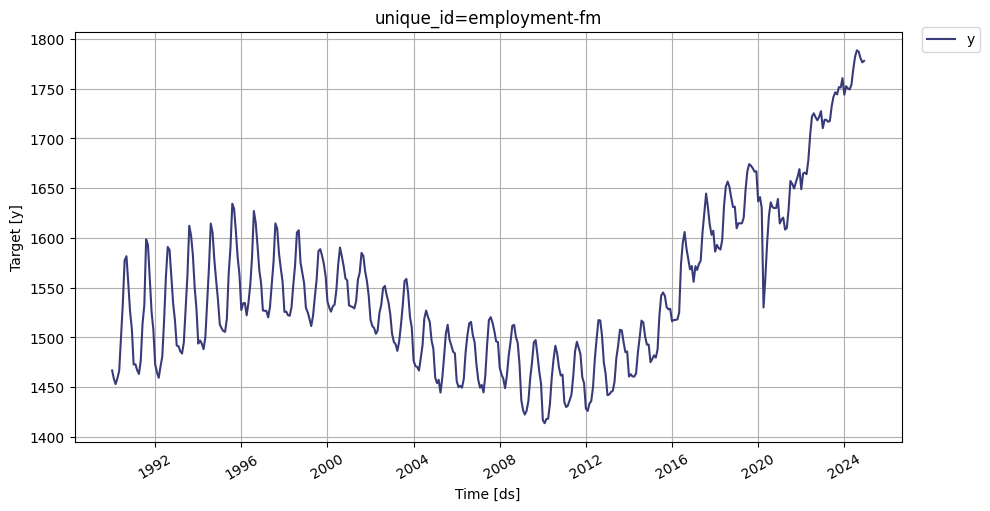

In [4]:
f = StatsForecast.plot(df)
f.set_figwidth(9)
f.set_figheight(5)
f

- strong seasonal pattern early years (yearly)
- wave like trend
- later years more like upward trend + seasonality + noise
- starting from 2005 its trend and variance are closer to latest years

#### Log-Scale transformations for seasonality 

In [5]:
season_length = 12

df = df[df["ds"] >= "2005-01-01"]

# variance volatile with trend
# log transform
df["y"] = np.log(df["y"])

df.head()

,unique_id,ds,y
180,employment-fm,2005-01-01,7.286055
181,employment-fm,2005-02-01,7.282074
182,employment-fm,2005-03-01,7.284478
183,employment-fm,2005-04-01,7.275588
184,employment-fm,2005-05-01,7.285369


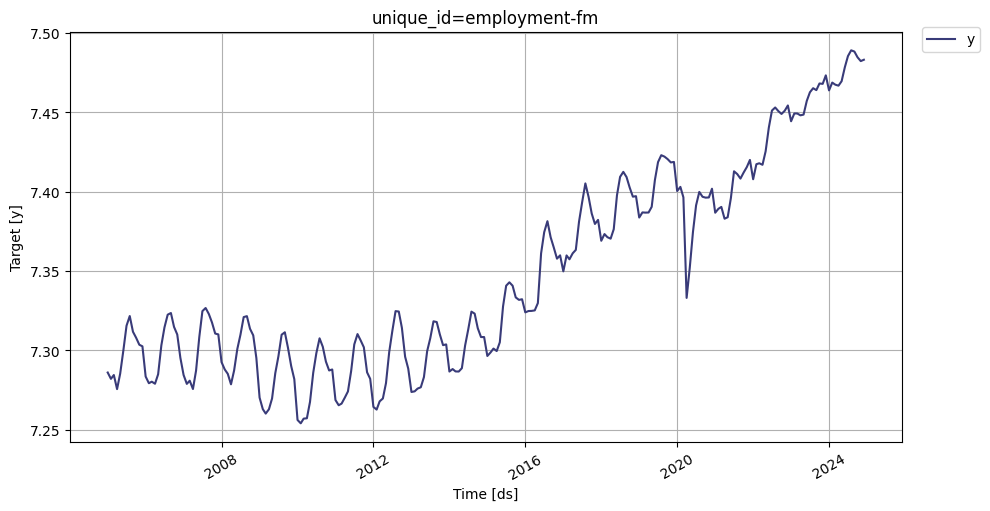

In [6]:
f = StatsForecast.plot(df)
f.set_figwidth(9)
f.set_figheight(5)
f

#EDA STL

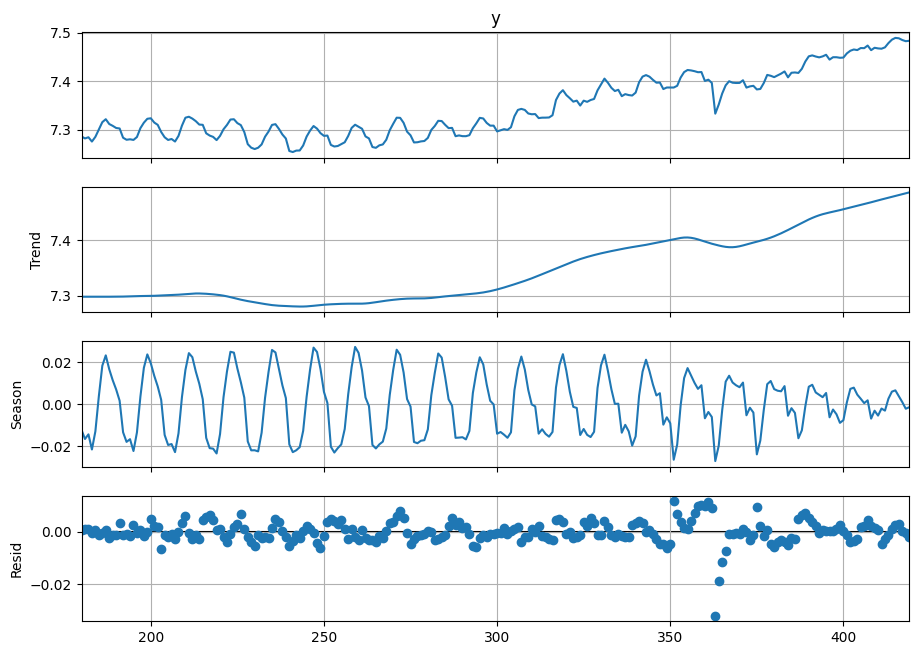

In [7]:
res = STL(df['y'], period=12).fit()

f = res.plot()
f.set_figwidth(10)
f.set_figheight(7)

#Non-Stationary stat-tests

In [8]:
adf_result = adfuller(df['y'])
adf_result

(np.float64(0.9922486233312985),
 np.float64(0.9941834854989334),
 12,
 227,
 {'1%': np.float64(-3.4594900381360034),
  '5%': np.float64(-2.8743581895178485),
  '10%': np.float64(-2.573601605503697)},
 np.float64(-1592.5174611649745))

In [9]:
if adf_result[1] > 0.05:
    print("ADF: Failed to reject null hypothesis -> The series is non-stationary")

ADF: Failed to reject null hypothesis -> The series is non-stationary


In [10]:
kpss_result = kpss(df['y'])
kpss_result

/var/folders/d7/5xjp058538n1_2xf1mtj_bwr0000gn/T/ipykernel_39955/3429579584.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df['y'])


(np.float64(2.0135906376258466),
 np.float64(0.01),
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [11]:
if kpss_result[1] < 0.05:
    print(f'KPSS: Null hypothesis rejected -> series is non-stationary')

KPSS: Null hypothesis rejected -> series is non-stationary


#### Fit Models

In [12]:
forecast_horizon = 12

sf = StatsForecast(
    models=[
        SeasonalNaive(season_length=season_length),
        AutoARIMA(season_length=season_length, max_d=1, max_D=1),
        AutoETS(season_length=season_length),

    ],
    freq="MS",
)


sf.fit(df)

# forecast horizon 12 months, still log-scaled
forecast_df = sf.predict(h=forecast_horizon)
forecast_df

,unique_id,ds,SeasonalNaive,AutoARIMA,AutoETS
0,employment-fm,2025-01-01,7.463879,7.471070,7.467866
1,employment-fm,2025-02-01,7.468799,7.475746,7.468173
2,employment-fm,2025-03-01,7.467485,7.475024,7.463179
3,employment-fm,2025-04-01,7.466857,7.468815,7.453737
4,employment-fm,2025-05-01,7.469654,7.473480,7.452080
5,employment-fm,2025-06-01,7.478452,7.487075,7.462933
6,employment-fm,2025-07-01,7.485492,7.497228,7.474981
7,employment-fm,2025-08-01,7.489133,7.500919,7.481980
8,employment-fm,2025-09-01,7.488349,7.498779,7.482866
9,employment-fm,2025-10-01,7.484762,7.497326,7.482998


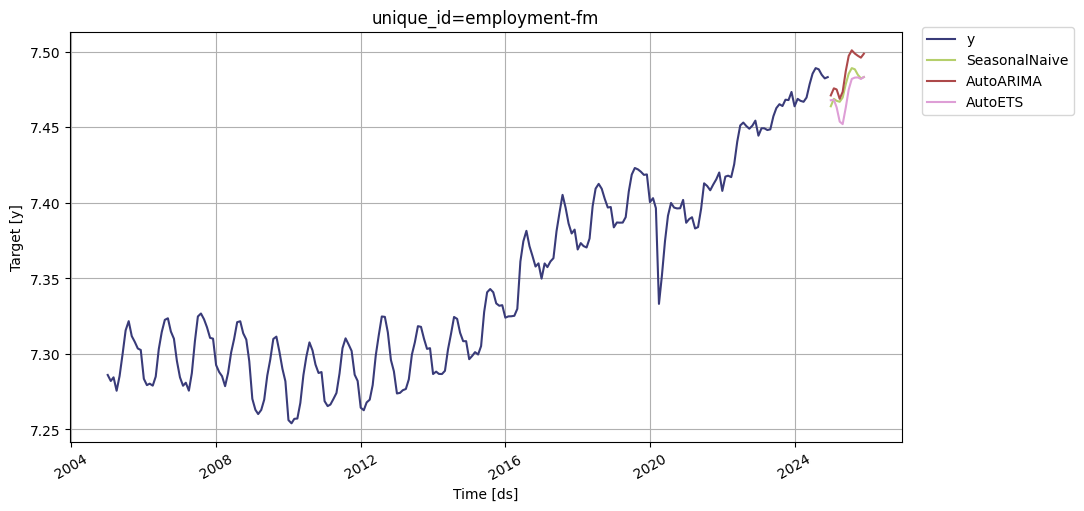

In [13]:
f = sf.plot(df, forecast_df, models=['SeasonalNaive', 'AutoARIMA', 'AutoETS'])
f.set_figwidth(9)
f.set_figheight(5)
f

### Final Predicted Ans

In [14]:
# back-transform to original scale
forecast_df["AutoARIMA"] = np.exp(forecast_df["AutoARIMA"])
forecast_df['AutoARIMA']

0     1756.485670
1     1764.717815
2     1763.444717
3     1752.529296
4     1760.723173
5     1784.823228
6     1803.037903
7     1809.704837
8     1805.835430
9     1803.214332
10    1800.947911
11    1805.659539
Name: AutoARIMA, dtype: float64

### Cross-Validation

In [15]:
cv_df = sf.cross_validation(
    df=df,
    h=12,          # 12 months ahead
    step_size=12,  # move 1 year forward each iteration
    n_windows=4    # last 4 years as validation
)

cv_df.head(25)

,unique_id,ds,cutoff,y,SeasonalNaive,AutoARIMA,AutoETS
0,employment-fm,2021-01-01,2020-12-01,7.386781,7.400437,7.386926,7.379246
1,employment-fm,2021-02-01,2020-12-01,7.389255,7.403061,7.390324,7.381526
2,employment-fm,2021-03-01,2020-12-01,7.390428,7.396458,7.387237,7.376971
3,employment-fm,2021-04-01,2020-12-01,7.382995,7.333088,7.361723,7.354868
4,employment-fm,2021-05-01,2020-12-01,7.383927,7.351928,7.371900,7.372202
5,employment-fm,2021-06-01,2020-12-01,7.396090,7.374629,7.392731,7.394562
6,employment-fm,2021-07-01,2020-12-01,7.412885,7.391415,7.406506,7.408140
7,employment-fm,2021-08-01,2020-12-01,7.411133,7.399887,7.413345,7.413926
8,employment-fm,2021-09-01,2020-12-01,7.408288,7.396826,7.410056,7.409703
9,employment-fm,2021-10-01,2020-12-01,7.412040,7.396274,7.406707,7.404903


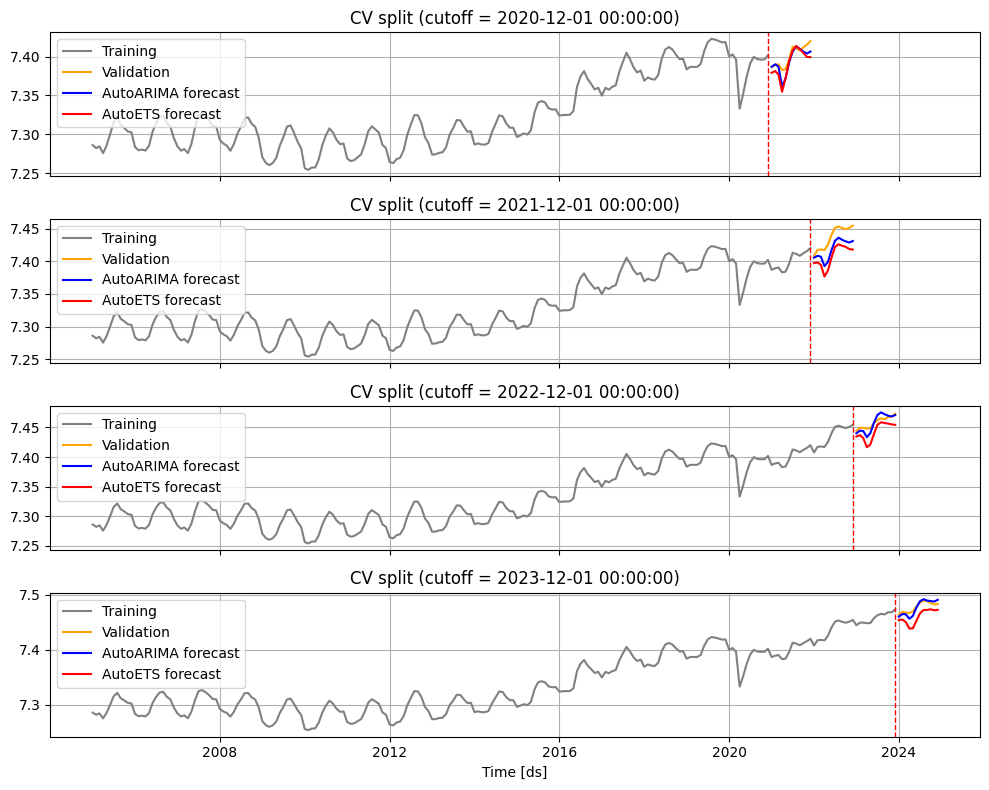

In [16]:
cutoffs = cv_df['cutoff'].unique()

fig, axes = plt.subplots(
    nrows=len(cutoffs),
    figsize=(10, 2 * len(cutoffs)),
    sharex=True
)

if len(cutoffs) == 1:
    axes = [axes]

for ax, cutoff in zip(axes, cutoffs):
    # training data: ds <= cutoff
    train = df[df['ds'] <= cutoff]

    # validation data: next 12 months after cutoff
    val = df[
        (df['ds'] > cutoff) &
        (df['ds'] <= cutoff + pd.DateOffset(months=12))
    ]

    # CV forecasts for this cutoff
    fcst = cv_df[cv_df['cutoff'] == cutoff]

    ax.plot(train['ds'], train['y'], color='gray', label='Training')
    ax.plot(val['ds'], val['y'], color='orange', label='Validation')

    ax.plot(
        fcst['ds'],
        fcst['AutoARIMA'],
        color='blue',
        label='AutoARIMA forecast'
    )
    ax.plot(
        fcst['ds'],
        fcst['AutoETS'],
        color='red',
        label='AutoETS forecast'
    )

    ax.axvline(cutoff, color='red', linestyle='--', linewidth=1)
    ax.set_title(f'CV split (cutoff = {cutoff})')
    ax.legend(loc='upper left')

plt.xlabel('Time [ds]')
plt.tight_layout()
plt.show()


In [17]:
eval_res = evaluate(cv_df, metrics=[mae, rmse], models=['SeasonalNaive', 'AutoARIMA', 'AutoETS'])
eval_res

,unique_id,cutoff,metric,SeasonalNaive,AutoARIMA,AutoETS
0,employment-fm,2020-12-01,mae,0.019507,0.006799,0.010212
1,employment-fm,2021-12-01,mae,0.035519,0.018088,0.029025
2,employment-fm,2022-12-01,mae,0.021921,0.005792,0.015058
3,employment-fm,2023-12-01,mae,0.019143,0.004467,0.017578
4,employment-fm,2020-12-01,rmse,0.022456,0.009161,0.012861
5,employment-fm,2021-12-01,rmse,0.036155,0.019349,0.030173
6,employment-fm,2022-12-01,rmse,0.023461,0.007088,0.016896
7,employment-fm,2023-12-01,rmse,0.019548,0.005253,0.018873


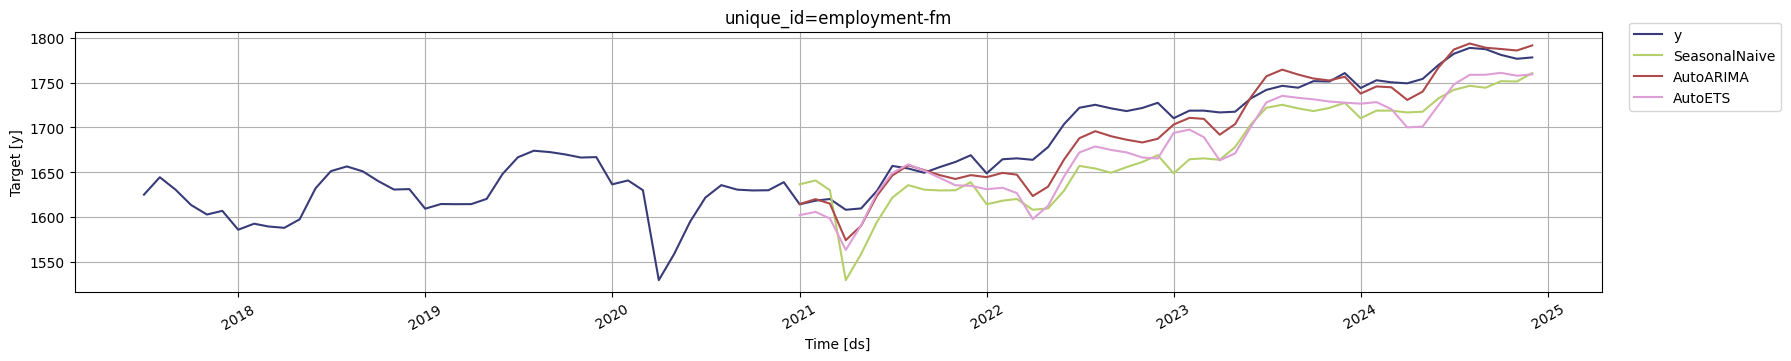

In [18]:
# rescaled to orignal
cv_df['SeasonalNaive'] = np.exp(cv_df['SeasonalNaive'])
cv_df['AutoARIMA'] = np.exp(cv_df['AutoARIMA'])
cv_df['AutoETS'] = np.exp(cv_df['AutoETS'])

df['y'] = np.exp(df['y'])

StatsForecast.plot(
    df[150:],
    cv_df[['unique_id', 'ds', 'SeasonalNaive', 'AutoARIMA', 'AutoETS']]
)